In [188]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from random import shuffle
from torch.nn.parameter import Parameter
print( torch.cuda.is_available(), torch.cuda.current_device(),torch.cuda.get_device_name(0))
if torch.cuda.is_available():
    dev = "cuda:2"
else:
    dev = "cpu"

device = torch.device(dev)
print( torch.cuda.is_available(), torch.cuda.current_device(),torch.cuda.get_device_name(0))

import numpy as np
import os
import sys
import os
import yaml
import pandas as pd
import numpy as np
import os
import glob
from collections import OrderedDict
import pickle

import multiprocessing as mp
from sklearn.metrics.pairwise import cosine_similarity
try:
    from . import utils_1
except:
    import utils_1
    

True 0 Tesla P100-PCIE-16GB
True 0 Tesla P100-PCIE-16GB


In [11]:
CONFIG_FILE = 'config_1.yaml'
DIR = None
OP_DIR = None
modelData_SaveDir = None
DATA_DIR = None
num_jobs = None
CONFIG = None
Refresh_Embeddings = None
logger = None
domain_dims = None
train_data_file = None
id_col = 'PanjivaRecordID'
# ------ #

def get_domain_dims(dd_file_path):
    with open(dd_file_path, 'rb') as fh:
        domain_dims = pickle.load(fh)
    _tmpDF = pd.DataFrame.from_dict(domain_dims, orient='index')
    _tmpDF = _tmpDF.reset_index()
    _tmpDF = _tmpDF.rename(columns={'index': 'domain'})
    _tmpDF = _tmpDF.sort_values(by=['domain'])
    res = {k: v for k, v in zip(_tmpDF['domain'], _tmpDF[0])}
    return res


def setup_config(_DIR=None):
    global CONFIG_FILE
    global DATA_DIR
    global modelData_SaveDir
    global OP_DIR
    global DIR
    global num_jobs
    global Refresh_Embeddings
    global logger
    global CONFIG
    global domain_dims
    global train_data_file
    
    with open(CONFIG_FILE) as f:
        CONFIG = yaml.safe_load(f)
    if _DIR is None:
        DIR = CONFIG['DIR']
    else:
        DIR = _DIR

    DATA_DIR = os.path.join(CONFIG['DATA_DIR'])
    modelData_SaveDir = os.path.join(
        CONFIG['model_data_save_dir'],
        DIR
    )
    train_data_file = CONFIG['train_data_file']
    
    if not os.path.exists(CONFIG['OP_DIR']):
        os.mkdir(CONFIG['OP_DIR'])
    OP_DIR = os.path.join(CONFIG['OP_DIR'], DIR)
    if not os.path.exists(OP_DIR):
        os.mkdir(OP_DIR)

    Refresh_Embeddings = CONFIG[DIR]['Refresh_Embeddings']
    cpu_count = mp.cpu_count()
    num_jobs = min(cpu_count, CONFIG['num_jobs'])

    if not os.path.exists(CONFIG['model_data_save_dir']):
        os.mkdir(CONFIG['model_data_save_dir'])

    if not os.path.exists(modelData_SaveDir):
        os.mkdir(modelData_SaveDir)
    
    domain_dims_file = os.path.join(DATA_DIR, DIR, "domain_dims.pkl")
    domain_dims = get_domain_dims(domain_dims_file)
    print(' Set up config')
    return

setup_config()

 Set up config


In [12]:
def create_coocc_matrix(df, col_1, col_2):
    set_elements_1 = set(list(df[col_1]))
    set_elements_2 = set(list(df[col_2]))
    count_1 = len(set_elements_1)
    count_2 = len(set_elements_2)
    coocc = np.zeros([count_1, count_2])
    df = df[[col_1, col_2]]
    new_df = df.groupby([col_1, col_2]).size().reset_index(name='count')

    for _, row in new_df.iterrows():
        i = row[col_1]
        j = row[col_2]
        coocc[i][j] = row['count']

    print('Col 1 & 2', col_1, col_2, coocc.shape, '>>', (count_1, count_2))
    return coocc



def get_coOccMatrix_dict(df, id_col):
    columns = list(df.columns)
    columns.remove(id_col)
    columns = list(sorted(columns))
    columnWise_coOccMatrix_dict = {}

    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col_1 = columns[i]
            col_2 = columns[j]
            key = col_1 + '_+_' + col_2
            res = create_coocc_matrix(df, col_1, col_2)
            columnWise_coOccMatrix_dict[key] = res
    columnWise_coOccMatrix_dict = OrderedDict(columnWise_coOccMatrix_dict)
    return columnWise_coOccMatrix_dict

In [13]:
src_DIR = os.path.join(DATA_DIR, DIR)
training_data_file = CONFIG['train_data_file']
train_df = pd.read_csv(os.path.join(src_DIR, train_data_file))
feature_cols = list(train_df.columns)
feature_cols = list(feature_cols)
feature_cols.remove(id_col)
domains = sorted(feature_cols)
print(feature_cols)

model_data_save_dir = modelData_SaveDir

data = train_df[feature_cols].values
# ------------------------------- #
coOcc_dict_file = os.path.join(model_data_save_dir, "coOccMatrix_dict.pkl")
X_ij_file = os.path.join(model_data_save_dir, "X_ij.npy")
domain_dims_file = os.path.join(src_DIR, "domain_dims.pkl")
domain_dims = get_domain_dims(domain_dims_file)

['Carrier', 'ConsigneePanjivaID', 'HSCode', 'PortOfLading', 'PortOfUnlading', 'ShipmentDestination', 'ShipmentOrigin', 'ShipperPanjivaID']


In [14]:
domain_dims

{'Carrier': 548,
 'ConsigneePanjivaID': 5113,
 'HSCode': 95,
 'PortOfLading': 238,
 'PortOfUnlading': 64,
 'ShipmentDestination': 113,
 'ShipmentOrigin': 116,
 'ShipperPanjivaID': 6193}

In [189]:
# -----
# Check if pairwise co-occurrence dictionary exists
# -----
if os.path.exists(coOcc_dict_file):
    with open(coOcc_dict_file, 'rb') as fh:
        coOccMatrix_dict = pickle.load(fh)
else:
    coOccMatrix_dict = get_coOccMatrix_dict(train_df, id_col='PanjivaRecordID')
    with open(coOcc_dict_file, "wb") as fh:
        pickle.dump(coOccMatrix_dict, fh, pickle.HIGHEST_PROTOCOL)


# ----------------
# Ensure X_ij 
# ----------------
if os.path.exists(X_ij_file):
    with open(X_ij_file, 'rb') as fh:
        X_ij = np.load(fh)

else:
   
    nd = len(feature_cols)
    X_ij = np.zeros([data.shape[0], nd, nd])
    print( X_ij.shape )

    for i in range(nd):
        for j in range(nd):
            if i == j :
                for d in range(data.shape[0]):
                    X_ij[d][i][j] = 0
            else:
                if i < j: 
                    _i =i
                    _j =j
                else : 
                    _i =j
                    _j =i
                key = feature_cols[_i] + '_+_' + feature_cols[_j]
                
                for d in range(data.shape[0]):
                    e1 = data[d][_i]
                    e2 = data[d][_j]
                    X_ij[d][i][j] = coOccMatrix_dict[key][e1][e2]
                    
    X_ij = np.asarray(X_ij,np.int32)
    with open(X_ij_file, "wb") as fh:
        np.save(fh, X_ij)


            

In [190]:
nd = len(feature_cols)
X_ij_max = np.zeros([nd,nd])
for i in range(nd):
    for j in range(nd):
        if i==j : continue
        if i < j: 
            _i =i
            _j =j
        else : 
            _i =j
            _j =i
        key = feature_cols[_i] + '_+_' + feature_cols[_j]
        X_ij_max[i][j] = np.max(coOccMatrix_dict[key])
        

In [191]:
X_ij_max = X_ij_max+1

In [18]:

# =================================
# Co-occurrence based embedding model
# Projecting GloVe to multivariate categorical 
# =================================



In [19]:
# Calculate doamin wise MI
import math 

def MI(dff, x, y):
    
    df = dff.copy()
    f_x = 'f_x'
    f_y = 'f_y'
    f_xy = "f_xy"
    df[f_x] = df.groupby(x)[x].transform('count')/len(df)
    df[f_y] = df.groupby(y)[y].transform('count')/len(df)
    
    l = len(df)
    df_1 = df.groupby([x,y]).size().reset_index(name=f_xy)
    df_1[f_xy] = df_1[f_xy]/l
    
    df_1 = df_1.sort_values(by=[x,y])
    
    df_2 = df.drop_duplicates([x,y])
    df_2 = df_2.sort_values(by=[x,y])
    df_2 = df_2[[x,y,f_x,f_y]]
    
    df_3 = df_1.merge(df_2, how='inner', on =[x,y])
    def calc(row):
        return row[f_xy]*np.log(row[f_xy]/(row[f_x]*row[f_y]))
    
    df_3['m'] = df_3.apply(calc,axis=1)
    return np.sum(df_3['m'])


   

In [20]:
num_domains = len(domain_dims)
MI_domain_ij = np.ones([num_domains,num_domains])


domains_list = list(domain_dims.keys())
for i in range(num_domains):
    for j in range(i+1,num_domains):
        MI_domain_ij[i][j] = MI(train_df, domains_list[i], domains_list[j])
        MI_domain_ij[j][i] = MI_domain_ij[i][j]

In [38]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / (e_x.sum()/2)


In [192]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
MI_domain_ij_scaled = scaler.fit_transform(MI_domain_ij_scaled) + 1


In [193]:
# ====================== 
# Custom Loss function 
# ======================

# y : shape [ ?, d, d]
def custom_loss(y_pred, y_true):
    
    # X_ij shape should be [ d,d ]
    global X_ij_max
    global MI_domain_ij_scaled
    _MI = torch.FloatTensor(MI_domain_ij_scaled)
    _X_ij_max = torch.FloatTensor(X_ij_max)
    a = 0.9
    epsilon = 0.000001

    e1 = torch.pow(y_pred - torch.log(y_true + epsilon) , 2)
    
    _xij_m = _X_ij_max.repeat(y_pred.size()[0], 1, 1)
    z = y_true / _xij_m 
    
    s1 = torch.clamp(torch.pow(z,a), 0.05, 1.0)
    
    loss =  s1 * _MI * e1  
    sample_loss = torch.sum(loss,keepdim = False, dim=-1)
    sample_loss = torch.sum(sample_loss,keepdim = False, dim=-1)
    sample_loss = sample_loss/2
    return torch.mean(
        sample_loss
    )

In [194]:
class Net(nn.Module):

    def __init__(
        self, 
        emb_dim,
        domain_dims
    ):
        super(Net, self).__init__()
        self.num_domains = len(domain_dims)
        self.domain_dims = domain_dims
        self.emb_dim = emb_dim
        
        self.list_W_m = []
        self.list_W_c = []
        self.list_B_m = []
        self.list_B_c = []
        
        
        for d_idx in range(self.num_domains):
            e = nn.Embedding(num_embeddings= domain_dims[d_idx], embedding_dim=emb_dim)
            e.weight = Parameter(torch.Tensor(torch.empty(self.domain_dims[d_idx], emb_dim).uniform_(-1, 1)))
            self.register_parameter('e_'+str(d_idx), e.weight)
            self.list_W_m.append(e)
            
            e1 = nn.Embedding(num_embeddings= domain_dims[d_idx], embedding_dim=emb_dim)
            e1.weight = Parameter(torch.Tensor(torch.empty(self.domain_dims[d_idx], emb_dim).uniform_(-1, 1)))
            self.register_parameter('e1_'+str(d_idx), e1.weight)
            self.list_W_c.append(e1)
            
            b = nn.Embedding(num_embeddings= domain_dims[d_idx], embedding_dim=1)
            b.weight = Parameter(torch.Tensor(torch.empty(domain_dims[d_idx], 1).uniform_(-1, 1)))
            self.register_parameter('b_'+str(d_idx), b.weight)
            self.list_B_m.append(b)
            
            b1 = nn.Embedding(num_embeddings=domain_dims[d_idx], embedding_dim=1)
            b1._weight = Parameter(torch.Tensor(torch.empty(domain_dims[d_idx], 1).uniform_(-1, 1)))
            self.register_parameter('b1_'+str(d_idx), b1.weight)
            self.list_B_c.append(b1) 
            
    
    # --------------------------------------
    # Define network structure
    # x : [? , dims]
    # --------------------------------------
    def forward(self, x):
        split_x = torch.chunk(
            x, 
            chunks = self.num_domains, 
            dim = 1
        )
        
        nd = self.num_domains
        res = []
        for m_idx in range(nd):
            _zero = split_x[m_idx]*0
            _zero = _zero.type(torch.FloatTensor).view([-1,1,1])
            
            
            w_i = self.list_W_m[m_idx](split_x[m_idx])
            b_i = self.list_B_m[m_idx](split_x[m_idx])
            
            for c_idx in range(nd):
                if m_idx == c_idx : 
                    res.append(_zero)
                else:
                    w_j = self.list_W_c[c_idx](split_x[c_idx])
                    b_j = self.list_B_c[c_idx](split_x[c_idx])

                    s = torch.bmm(
                        w_i.view(-1, 1, self.emb_dim), 
                        w_j.view(-1, self.emb_dim, 1)
                    ) 
                    s = s + b_i + b_j
                    
                    res.append(s)

        # Reshape from  list [ [?,1] ...[?,d*d] ] to  [?, d ,d]
      
        res = torch.stack(
            res,
            dim=1
        )
        res = torch.squeeze(res,dim=-1)
        res = torch.squeeze(res,dim=-1)
        
        res = res.view([-1, nd, nd])
        return res
    
        

In [196]:
emb_dim = 64
domain_dims_vals = list( domain_dims.values() )

In [197]:
net = Net(emb_dim,domain_dims_vals)
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
criterion = custom_loss

In [198]:
len(list(net.parameters()))

32

In [199]:
train_x = train_df[feature_cols].values

In [200]:
X_ij.shape

(140382, 8, 8)

In [201]:
num_epochs = 100
bs = 128
log_interval = 100

In [202]:
num_batches = train_x.shape[0]//bs 

In [203]:

for epoch in range(num_epochs):
    # Shuffle
    ind_list = list(range(train_x.shape[0]))
    shuffle(ind_list)
    _train_x = train_x[ind_list,:]
    _y = X_ij[ind_list,:,:]
    _y = _y+1
    
    for batch_idx in range(num_batches+1):
        _x_pos = _train_x[batch_idx*bs:(batch_idx+1)*bs]
        _y_true = _y[batch_idx*bs:(batch_idx+1)*bs]
        # feed tensor
        _x_pos = torch.LongTensor(_x_pos)
        _y_true = torch.FloatTensor(_y_true)
        # ----- #
        optimizer.zero_grad()
        output = net(_x_pos)
       
        loss = criterion(output, _y_true)
        loss.backward()
        optimizer.step()
        # ----- #
        if batch_idx % log_interval == 0:
            print('Train ::  Epoch: {}, Batch {}, Loss {:4f}'.format(epoch, batch_idx,loss))
                        

Train ::  Epoch: 0, Batch 0, Loss 490.315155
Train ::  Epoch: 0, Batch 100, Loss 39.855339
Train ::  Epoch: 0, Batch 200, Loss 9.579609
Train ::  Epoch: 0, Batch 300, Loss 4.738073
Train ::  Epoch: 0, Batch 400, Loss 3.205403
Train ::  Epoch: 0, Batch 500, Loss 2.321314
Train ::  Epoch: 0, Batch 600, Loss 1.873317
Train ::  Epoch: 0, Batch 700, Loss 1.536324
Train ::  Epoch: 0, Batch 800, Loss 1.169533
Train ::  Epoch: 0, Batch 900, Loss 1.079208
Train ::  Epoch: 0, Batch 1000, Loss 0.741467
Train ::  Epoch: 1, Batch 0, Loss 0.664297
Train ::  Epoch: 1, Batch 100, Loss 0.590185
Train ::  Epoch: 1, Batch 200, Loss 0.578701
Train ::  Epoch: 1, Batch 300, Loss 0.490084
Train ::  Epoch: 1, Batch 400, Loss 0.581943
Train ::  Epoch: 1, Batch 500, Loss 0.537322
Train ::  Epoch: 1, Batch 600, Loss 0.427503
Train ::  Epoch: 1, Batch 700, Loss 0.402560
Train ::  Epoch: 1, Batch 800, Loss 0.425102
Train ::  Epoch: 1, Batch 900, Loss 0.346960
Train ::  Epoch: 1, Batch 1000, Loss 0.294175
Train :: 

In [204]:
weight_dict = OrderedDict({})
for i in range(len(domain_dims)):
    arr = (net.list_W_m[i].weight.detach().numpy() + net.list_W_c[i].weight.detach().numpy())/2
    print(arr.shape)
    _D = list(domain_dims.items())[i][0]
    weight_dict[_D] = arr

f_path = os.path.join(modelData_SaveDir,'emb_v2_weight_dict.pkl')
with open(f_path,'wb') as fh:
    pickle.dump(weight_dict, fh, pickle.HIGHEST_PROTOCOL)
    


(548, 64)
(5113, 64)
(95, 64)
(238, 64)
(64, 64)
(113, 64)
(116, 64)
(6193, 64)


In [205]:
def test(weight_dict):
    hscodeList = [10,20,25,35,45,50,55,75,80,90]

    for hscode in hscodeList:
        print('-----> ::: ',hscode)
        # find the 10 closest  to ShipmentDestination to HSCode in data
        df = train_df.loc[train_df['HSCode'] == hscode]
        df = df.groupby(['HSCode', 'ShipmentOrigin']).size().reset_index(name='counts')
        df = df.sort_values(by=['counts'])
       
        k_closest = df.tail(10)['ShipmentOrigin'].values
        print(k_closest)

        # hs_code_vec = wt[0][hscode] + bias[0][hscode]
        hs_code_vec = weight_dict['HSCode'][hscode]

        shp_dest_vec = []
        wt = weight_dict['ShipmentOrigin']
        for i in range(wt.shape[0]):
            r = wt[i]
            shp_dest_vec.append(r)

        res = {}
        for i in range(wt.shape[0]):
            a = np.reshape(shp_dest_vec[i], [1, -1])
            b = np.reshape(hs_code_vec, [1, -1])
            res[i] = np.dot(a, np.transpose(b))[0][0]

        new_df = pd.DataFrame(list(res.items()))
        new_df = new_df.sort_values(by=[1])
       
        new_df = new_df.tail(10)
        print(list(new_df[0]))
            

In [206]:
test(weight_dict)

-----> :::  10
[46  8 83]
[111, 14, 53, 100, 75, 83, 99, 20, 41, 79]
-----> :::  20
[46 34 21 85 22 64 81  7  8 11]
[11, 51, 34, 38, 8, 76, 22, 7, 64, 46]
-----> :::  25
[ 19 114  30  85  66  51  22  81  40  11]
[90, 108, 93, 27, 33, 22, 81, 11, 52, 40]
-----> :::  35
[66 81 11 30]
[41, 32, 69, 56, 4, 99, 79, 33, 3, 0]
-----> :::  45
[ 7 66 30 93 19 85 81 55 21 11]
[49, 46, 29, 24, 55, 114, 43, 81, 21, 11]
-----> :::  50
[23  7 81 40 30 87 21 22 85 11]
[7, 23, 40, 81, 30, 22, 21, 87, 11, 85]
-----> :::  55
[113 115  22   8  21  81  64  30  75  11]
[9, 95, 34, 1, 76, 102, 83, 6, 14, 33]
-----> :::  75
[ 30  40  76 115  11  81  33]
[83, 108, 96, 9, 15, 88, 45, 75, 78, 33]
-----> :::  80
[43  8 57 40 46 11 92]
[41, 36, 96, 102, 98, 34, 74, 47, 75, 92]
-----> :::  90
[ 80   7 115  85  22 113  38   8  11  66]
[98, 47, 87, 90, 45, 39, 38, 109, 113, 66]


In [162]:
adj_embeddings = {}
domains_list = list(domain_dims.keys())
MI_ij_dict = {}

for i in range(num_domains):
    for j in range(i+1, num_domains):
        _key = domains_list[i] + '_+_' + domains_list[j]
        MI_ij_dict[_key] = MI_domain_ij_scaled[i][j]


from sklearn.preprocessing import StandardScaler
for i in range(num_domains):
    domain_i = domains_list[i]
   
    adj_embeddings[domain_i] = np.zeros(
        weight_dict[domain_i].shape
    )

    domain_dim = domain_dims[domain_i]
    
    # -------------
    # For each entity in domain i
    # -------------
    for entity_id in range(domain_dim):
        res = 0
        # For each entity in domain j != i
        for domain_j in domains:
            if domain_j == domain_i: 
               
                continue
            pair = sorted([domain_i, domain_j])
            
            key = '_+_'.join(pair)
            mi_val = MI_ij_dict[key]
            
            coOcc_matrix = coOccMatrix_dict[key]
            if domain_i == pair[0]:
                arr = coOcc_matrix[entity_id, :]
            else:
                arr = coOcc_matrix[:, entity_id]
             
 
            sum_co_occ = max(np.sum(arr), 1)
            scale = np.reshape(arr  / sum_co_occ, [-1, 1]) 
            scale = np.power(scale, 2)
            
            emb_domain_j = weight_dict[domain_j]
            res_j = np.sum(scale  * emb_domain_j, axis=0)
            res = res + res_j

        res = 0.5 * (res + weight_dict[domain_i][entity_id])
        adj_embeddings[domain_i][entity_id] = res

In [166]:
test(adj_embeddings)

-----> :::  10
[46  8 83]
[115, 40, 59, 57, 28, 81, 98, 91, 55, 76]
-----> :::  25
[ 19 114  30  85  66  51  22  81  40  11]
[87, 21, 113, 85, 40, 7, 22, 77, 81, 11]
-----> :::  35
[66 81 11 30]
[6, 54, 68, 11, 73, 63, 0, 10, 26, 18]
-----> :::  40
[98 22 11 66  8 30 46  7 49 64]
[39, 87, 7, 11, 85, 23, 64, 77, 49, 113]
-----> :::  50
[23  7 81 40 30 87 21 22 85 11]
[113, 11, 40, 81, 21, 23, 77, 85, 22, 87]
-----> :::  55
[113 115  22   8  21  81  64  30  75  11]
[80, 22, 81, 49, 30, 56, 87, 11, 77, 113]
-----> :::  75
[ 30  40  76 115  11  81  33]
[33, 92, 39, 57, 108, 111, 43, 23, 7, 22]
-----> :::  90
[ 80   7 115  85  22 113  38   8  11  66]
[87, 7, 11, 66, 85, 23, 22, 56, 77, 113]


In [94]:
coOccMatrix_dict.keys()

odict_keys(['Carrier_+_ConsigneePanjivaID', 'Carrier_+_HSCode', 'Carrier_+_PortOfLading', 'Carrier_+_PortOfUnlading', 'Carrier_+_ShipmentDestination', 'Carrier_+_ShipmentOrigin', 'Carrier_+_ShipperPanjivaID', 'ConsigneePanjivaID_+_HSCode', 'ConsigneePanjivaID_+_PortOfLading', 'ConsigneePanjivaID_+_PortOfUnlading', 'ConsigneePanjivaID_+_ShipmentDestination', 'ConsigneePanjivaID_+_ShipmentOrigin', 'ConsigneePanjivaID_+_ShipperPanjivaID', 'HSCode_+_PortOfLading', 'HSCode_+_PortOfUnlading', 'HSCode_+_ShipmentDestination', 'HSCode_+_ShipmentOrigin', 'HSCode_+_ShipperPanjivaID', 'PortOfLading_+_PortOfUnlading', 'PortOfLading_+_ShipmentDestination', 'PortOfLading_+_ShipmentOrigin', 'PortOfLading_+_ShipperPanjivaID', 'PortOfUnlading_+_ShipmentDestination', 'PortOfUnlading_+_ShipmentOrigin', 'PortOfUnlading_+_ShipperPanjivaID', 'ShipmentDestination_+_ShipmentOrigin', 'ShipmentDestination_+_ShipperPanjivaID', 'ShipmentOrigin_+_ShipperPanjivaID'])

array([[ 2.,  2.,  2., ...,  9.,  2.,  2.],
       [ 2.,  8.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       ...,
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ..., 20.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.]])

In [233]:
print(coOccMatrix_dict['PortOfUnlading_+_ShipmentDestination'])
print(coOccMatrix_dict['PortOfUnlading_+_ShipmentDestination'][48][57])


[[1.6036e+04 0.0000e+00 3.8000e+01 ... 0.0000e+00 3.0000e+00 1.0000e+01]
 [1.0000e+01 0.0000e+00 7.1000e+01 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]
97.0


In [234]:
a = weight_dict['HSCode'][48]
b = weight_dict['ShipmentOrigin'][57]
np.dot(a, b)

-0.35755005

In [183]:
from sklearn.manifold import TSNE
X = weight_dict['PortOfLading']
X_embedded = TSNE(n_components=2, perplexity=8.0).fit_transform(X)

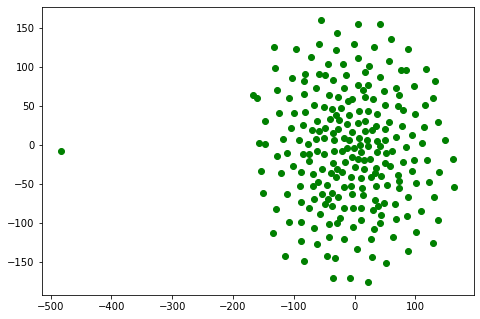

In [184]:
from matplotlib import pyplot as plt
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.scatter(X_embedded[:,0],X_embedded[:,1],color='g')
plt.show()